In [2]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
from datetime import timedelta
import torch
import dateutil
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import trange
# from TaPR_pkg import etapr
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
from kan import *
import torch.nn.functional as F

In [ ]:
from sklearn.metrics import r2_score

In [7]:
ALL_DATASET = sorted([x for x in Path("../../data/haiend-23.05/").glob("*.csv")])

In [8]:
ALL_DATASET

[PosixPath('../../data/haiend-23.05/end-test1.csv'),
 PosixPath('../../data/haiend-23.05/end-test2.csv'),
 PosixPath('../../data/haiend-23.05/end-train1.csv'),
 PosixPath('../../data/haiend-23.05/end-train2.csv'),
 PosixPath('../../data/haiend-23.05/end-train3.csv'),
 PosixPath('../../data/haiend-23.05/end-train4.csv'),
 PosixPath('../../data/haiend-23.05/label-test1.csv'),
 PosixPath('../../data/haiend-23.05/label-test2.csv')]

In [9]:
TRAIN_DATASET = sorted([x for x in ALL_DATASET if 'end-train' in x.stem])
TEST_DATASET = sorted([x for x in ALL_DATASET if 'end-test' in x.stem])
LABEL_DATASET = sorted([x for x in ALL_DATASET if 'label-test' in x.stem])

In [10]:
LABEL_DATASET

[PosixPath('../../data/haiend-23.05/label-test1.csv'),
 PosixPath('../../data/haiend-23.05/label-test2.csv')]

In [ ]:
def dataframe_from_csv(target):
    return pd.read_csv(target).rename(columns=lambda x: x.strip())

def dataframe_from_csvs(targets):
    return pd.concat([dataframe_from_csv(x) for x in targets])

In [ ]:
def standardize_and_add_seconds(ts_list):
    updated_list = []
    seconds_counter = 1
    adding_seconds = False
    
    for ts in ts_list:
        try:
            dt = pd.to_datetime(ts, format='%Y-%m-%d %H:%M:%S', errors='coerce')

            if pd.isnull(dt): 
                dt = pd.to_datetime(ts, format='%Y-%m-%d %H:%M', errors='coerce')
                if not pd.isnull(dt): 
                    ts = f"{ts}:{seconds_counter:02d}"
                    seconds_counter += 1
                    if seconds_counter > 59:
                        seconds_counter = 0 
                else:
                    updated_list.append(ts)
                    continue
            else:
                updated_list.append(ts)
                continue

            dt = pd.to_datetime(ts)
            ts = dt.strftime('%Y-%m-%d %H:%M:%S')
            updated_list.append(ts)

        except Exception as e:
            print(f"Ошибка при обработке строки '{ts}': {e}")
            updated_list.append(ts)

    return updated_list

In [ ]:
LABEL_DF_RAW = dataframe_from_csvs(LABEL_DATASET)
LABEL_DF_RAW

,timestamp,label
0,2022-08-12 16:00:01,0
1,2022-08-12 16:00:02,0
2,2022-08-12 16:00:03,0
3,2022-08-12 16:00:04,0
4,2022-08-12 16:00:05,0
...,...,...
230395,2022-08-19 15:59,0
230396,2022-08-19 15:59,0
230397,2022-08-19 15:59,0
230398,2022-08-19 15:59,0


In [ ]:
label_counts = LABEL_DF_RAW['label'].value_counts()

print(label_counts)

label
0    273016
1     11384
Name: count, dtype: int64


In [ ]:
LABEL_DF_RAW['timestamp'] = standardize_and_add_seconds(LABEL_DF_RAW['timestamp'])

In [ ]:
TRAIN_DF_RAW = dataframe_from_csvs(TRAIN_DATASET)
TRAIN_DF_RAW

,Timestamp,DM-PP01-R,DM-FT01Z,DM-FT02Z,DM-FT03Z,1001.2-OUT,1001.7-OUT1,1001.7-OUT2,1001.8-OUT,1002.2-OUT,...,DM-PCV01-D,DM-PCV01-Z,DM-PCV02-D,DM-PCV02-Z,DM-PIT01,DM-PIT02,DM-PWIT-03,DM-TIT01,DM-TIT02,DM-TWIT-03
0,2022-08-04 18:00:00,0,287.202423,3166.977539,983.985901,0,0,0,0,0,...,27.862734,28.642271,12.0,11.819457,1.260528,0.375519,0.000585,30.187988,35.208130,27.224792
1,2022-08-04 18:00:01,0,293.160736,3162.222900,982.681396,0,0,0,0,0,...,27.824905,28.306576,12.0,11.819457,1.249084,0.376282,0.000585,30.187988,35.192867,27.224792
2,2022-08-04 18:00:02,0,286.209137,3164.099609,983.550964,0,0,0,0,0,...,27.853020,28.283689,12.0,11.819457,1.242981,0.376282,0.000585,30.187988,35.177608,27.224792
3,2022-08-04 18:00:03,0,287.202423,3159.595459,983.550964,0,0,0,0,0,...,27.844429,28.298950,12.0,11.819457,1.239166,0.376282,0.000585,30.203249,35.192867,27.224792
4,2022-08-04 18:00:04,0,286.209137,3159.845459,983.550964,0,0,0,0,0,...,27.837145,28.268433,12.0,11.819457,1.237640,0.375519,0.000585,30.187988,35.177608,27.224792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197995,2022-08-24 23:59:55,0,328.912140,3118.305176,1025.098389,0,0,0,0,0,...,29.186384,28.741451,12.0,12.269591,1.119385,0.401459,0.000554,29.104614,34.094234,26.203400
197996,2022-08-24 23:59:56,0,330.898376,3120.807617,1025.098389,0,0,0,0,0,...,29.206390,28.840637,12.0,12.269591,1.119385,0.403747,0.000554,29.089354,34.109497,26.203400
197997,2022-08-24 23:59:57,0,324.940063,3121.558105,1025.417480,0,0,0,0,0,...,29.217766,28.863523,12.0,12.269591,1.119385,0.402222,0.000554,29.089354,34.094234,26.203400
197998,2022-08-24 23:59:58,0,324.940063,3122.183838,1023.822876,0,0,0,0,0,...,29.257380,28.863523,12.0,12.269591,1.119385,0.402985,0.000554,29.089354,34.094234,26.203400


In [ ]:
TRAIN_DF_RAW.shape

(896400, 226)

In [ ]:
TIMESTAMP_FIELD = "Timestamp"
IDSTAMP_FIELD = 'id'
ATTACK_FIELD = "attack"
VALID_COLUMNS_IN_TRAIN_DATASET = TRAIN_DF_RAW.columns.drop([TIMESTAMP_FIELD])
VALID_COLUMNS_IN_TRAIN_DATASET

Index(['DM-PP01-R', 'DM-FT01Z', 'DM-FT02Z', 'DM-FT03Z', '1001.2-OUT',
       '1001.7-OUT1', '1001.7-OUT2', '1001.8-OUT', '1002.2-OUT', '1002.6-OUT',
       ...
       'DM-PCV01-D', 'DM-PCV01-Z', 'DM-PCV02-D', 'DM-PCV02-Z', 'DM-PIT01',
       'DM-PIT02', 'DM-PWIT-03', 'DM-TIT01', 'DM-TIT02', 'DM-TWIT-03'],
      dtype='object', length=225)

In [ ]:
TAG_MIN = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].min()
TAG_MAX = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].max()

In [ ]:
def normalize(df):
    ndf = df.copy()
    for c in df.columns:
        if TAG_MIN[c] == TAG_MAX[c]:
            ndf[c] = df[c] - TAG_MIN[c]
        else:
            ndf[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
    return ndf

In [ ]:
TRAIN_DF = normalize(TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TRAIN_DF

,DM-PP01-R,DM-FT01Z,DM-FT02Z,DM-FT03Z,1001.2-OUT,1001.7-OUT1,1001.7-OUT2,1001.8-OUT,1002.2-OUT,1002.6-OUT,...,DM-PCV01-D,DM-PCV01-Z,DM-PCV02-D,DM-PCV02-Z,DM-PIT01,DM-PIT02,DM-PWIT-03,DM-TIT01,DM-TIT02,DM-TWIT-03
0,0.0,0.318709,0.992769,0.363228,0.0,0.0,0.0,0.0,0.0,0.0,...,0.480624,0.481850,0.0,0.032949,0.500725,0.052045,0.476301,0.390071,0.381156,0.336387
1,0.0,0.324809,0.991411,0.354615,0.0,0.0,0.0,0.0,0.0,0.0,...,0.479580,0.472601,0.0,0.032949,0.494134,0.052608,0.476301,0.390071,0.379209,0.336387
2,0.0,0.318306,0.991820,0.359529,0.0,0.0,0.0,0.0,0.0,0.0,...,0.480255,0.471143,0.0,0.032949,0.490057,0.052659,0.476301,0.390071,0.377104,0.336387
3,0.0,0.318669,0.990587,0.360015,0.0,0.0,0.0,0.0,0.0,0.0,...,0.480087,0.471415,0.0,0.032949,0.487478,0.052664,0.476301,0.392199,0.378823,0.336387
4,0.0,0.317698,0.990535,0.360064,0.0,0.0,0.0,0.0,0.0,0.0,...,0.479871,0.470610,0.0,0.032949,0.486350,0.052107,0.476301,0.390284,0.377068,0.336387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197995,0.0,0.365878,0.977821,0.661557,0.0,0.0,0.0,0.0,0.0,0.0,...,0.520755,0.484851,0.0,0.130148,0.411213,0.073178,0.474633,0.221986,0.225033,0.135317
197996,0.0,0.367710,0.978223,0.661801,0.0,0.0,0.0,0.0,0.0,0.0,...,0.521370,0.487560,0.0,0.130148,0.411300,0.074789,0.474633,0.220071,0.226786,0.135317
197997,0.0,0.361854,0.978475,0.663912,0.0,0.0,0.0,0.0,0.0,0.0,...,0.521742,0.488455,0.0,0.130148,0.411309,0.073836,0.474633,0.219879,0.225033,0.135317
197998,0.0,0.361269,0.978677,0.653699,0.0,0.0,0.0,0.0,0.0,0.0,...,0.522863,0.488545,0.0,0.130148,0.411310,0.074298,0.474633,0.219860,0.224858,0.135317


In [ ]:
WINDOW_GIVEN = 99
WINDOW_SIZE = 100


class HaiDataset(Dataset):
    def __init__(self, timestamps, df, stride=1, attacks=None):
        self.ts = np.array(timestamps)
        self.tag_values = np.array(df, dtype=np.float32)
        self.valid_idxs = []
        for L in trange(len(self.ts) - WINDOW_SIZE + 1):
            R = L + WINDOW_SIZE - 1
            if dateutil.parser.parse(self.ts[R]) - dateutil.parser.parse(
                self.ts[L]
            ) == timedelta(seconds=WINDOW_SIZE - 1):
                self.valid_idxs.append(L)
        self.valid_idxs = np.array(self.valid_idxs, dtype=np.int32)[::stride]
        self.n_idxs = len(self.valid_idxs)
        print(f"# of valid windows: {self.n_idxs}")
        if attacks is not None:
            self.attacks = np.array(attacks, dtype=np.float32)
            self.with_attack = True
        else:
            self.with_attack = False

    def __len__(self):
        return self.n_idxs

    def __getitem__(self, idx):
        i = self.valid_idxs[idx]
        last = i + WINDOW_SIZE - 1
        item = {"attack": self.attacks[last]} if self.with_attack else {}
        item["ts"] = self.ts[i + WINDOW_SIZE - 1]
        item["given"] = torch.from_numpy(self.tag_values[i : i + WINDOW_GIVEN])
        item["answer"] = torch.from_numpy(self.tag_values[last])
        return item

In [ ]:
HAI_DATASET_TRAIN = HaiDataset(TRAIN_DF_RAW[TIMESTAMP_FIELD], TRAIN_DF, stride=10)
HAI_DATASET_TRAIN[0]

  0%|          | 0/896301 [00:00<?, ?it/s]

# of valid windows: 89601


{'ts': '2022-08-04 18:01:39',
 'given': tensor([[0.0000, 0.3187, 0.9928,  ..., 0.3901, 0.3812, 0.3364],
         [0.0000, 0.3248, 0.9914,  ..., 0.3901, 0.3792, 0.3364],
         [0.0000, 0.3183, 0.9918,  ..., 0.3901, 0.3771, 0.3364],
         ...,
         [0.0000, 0.3443, 0.9892,  ..., 0.4021, 0.3854, 0.3077],
         [0.0000, 0.3474, 0.9908,  ..., 0.4040, 0.3874, 0.3077],
         [0.0000, 0.3508, 0.9921,  ..., 0.4021, 0.3837, 0.3077]]),
 'answer': tensor([0.0000, 0.3441, 0.9894, 0.3247, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.

In [ ]:
def train_kan(dataset, model, batch_size, n_epochs, device='cpu'):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.AdamW(model.parameters())
    loss_fn = torch.nn.MSELoss()  
    mae_loss_fn = torch.nn.L1Loss()  
    
    epochs = trange(n_epochs, desc="training")
    best = {"loss_mse": sys.float_info.max}
    loss_history = []
    mae_history = []
    r2_history = []
    
    model.to(device)
    
    for e in epochs:
        epoch_loss = 0
        epoch_mae = 0
        all_answers = []
        all_guesses = []

        for batch in dataloader:
            optimizer.zero_grad()

            given = batch["given"].to(device)
            guess = model(given)
            answer = batch["answer"].to(device)
            
            mse_loss = loss_fn(answer, guess)
            mae_loss = mae_loss_fn(answer, guess)
            mse_loss.backward()
            optimizer.step()

            epoch_loss += mse_loss.item()
            epoch_mae += mae_loss.item()

            all_answers.append(answer.detach().cpu().numpy())
            all_guesses.append(guess.detach().cpu().numpy())
        
        all_answers = np.concatenate(all_answers)
        all_guesses = np.concatenate(all_guesses)
        r2 = r2_score(all_answers, all_guesses)
        
        loss_history.append(epoch_loss)
        mae_history.append(epoch_mae)
        r2_history.append(r2)
        
        epochs.set_postfix_str(f"loss: {epoch_loss:.6f}, MAE: {epoch_mae:.6f}, R^2: {r2:.6f}")
        
        if epoch_loss < best["loss_mse"]:
            best["state"] = model.state_dict()
            best["loss_mse"] = epoch_loss
            best["loss_r2"] = r2
            best["loss_mae"] = epoch_mae
            best["epoch"] = e + 1
    
    return best, loss_history, mae_history, r2_history

# KAN B-spline

In [ ]:
def b_splines(x, grid, k):
    """Generate B-splines.

    Args:
        x (torch.Tensor): [batch_size_size, in_dim]
        grid (torch.Tensor): [in_dim, grid_size + 2*k + 1]
        k (int): degree of B-splines

    Returns:
        (torch.Tenosr): [batch_size, in_dim, grid_size + k]
    """

    x = x.unsqueeze(-1)

    value = (x >= grid[:, :-1]) * (x < grid[:, 1:])
    for p in range(1, k + 1):
        value = (x - grid[:, : -(p + 1)]) / (
            grid[:, p:-1] - grid[:, : -(p + 1)]
        ) * value[:, :, :-1] + (grid[:, p + 1 :] - x) / (
            grid[:, p + 1 :] - grid[:, 1:(-p)]
        ) * value[
            :, :, 1:
        ]

    return value


def curve2coeff(x, y, grid, k, eps=1e-8):
    """Calculate coefficients of B-splines.

    Args:
        x_eval (torch.Tensor): [batch_size, in_dim]
        y_eval (torch.Tensor): [batch_size, in_dim, out_dim]
        grid (torch.Tensor): [in_dim, grid_size + 2*k + 1]
        k (int): degree of B-splines

    Returns:
        (torch.Tensor): [out_dim, in_dim, grid_size + k]
    """

    splines = b_splines(x, grid, k).transpose(0, 1)

    device = splines.device
    if device != "cpu":
        splines = splines.cpu()
        y = y.cpu()

    # [in_dim, batch_size, grid_size + k] @ [in_dim, grid_size + k, out_dim] - [in_dim, batch_size, out_dim] = 0
    value = torch.linalg.lstsq(splines, y.transpose(0, 1)).solution

    value = value.to(device)

    # [in_dim, grid_size + k, out_dim] -> [out_dim, in_dim, grid_size + k]
    value = value.permute(2, 0, 1)

    return value

In [ ]:
class KANLinear(torch.nn.Module):
    def __init__(
        self,
        in_dim,
        out_dim,
        grid_size=5,
        k=3,
        noise_scale=0.1,
        noise_scale_base=0.1,
        scale_spline=1.0,
        base_fun=torch.nn.SiLU(),
        bias=True,
        grid_eps=0.02,
        grid_range=[-1, +1],
        bias_trainable=True,
        sp_trainable=True,
        sb_trainable=True,
        device="cpu",
    ):
        super().__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim 
        self.k = k
        self.base_fun = base_fun
        self.grid_eps = grid_eps
        self.size = in_dim * out_dim
        self.grid_size = grid_size
        self.device = device

        step = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            torch.arange(-k, grid_size + k + 1, device=device) * step + grid_range[0]
        ).repeat(self.in_dim, 1)
        self.register_buffer("grid", grid)  # grid [in_dim, grid_size + 2*k + 1]

        noise = (
            (torch.rand(grid_size + 1, in_dim, out_dim, device=device) - 1 / 2)
            * noise_scale
            / self.grid_size
        )
        self.coeff = torch.nn.Parameter(
            curve2coeff(
                x=self.grid.T[k:-k],  # [grid_size + 1, in_dim]
                y=noise,  # [grid_size + 1, in_dim, out_dim]
                grid=self.grid,
                k=k,
            ).contiguous()
        )  # [out_dim, in_dim, grid_size + k]

        self.scale_base = torch.nn.Parameter(
            (
                1 / (in_dim**0.5)
                + (torch.randn(self.out_dim, self.in_dim, device=device) * 2 - 1)
                * noise_scale_base
            ),
            requires_grad=sb_trainable,
        )
        self.scale_spline = torch.nn.Parameter(
            torch.full(
                (
                    out_dim,
                    in_dim,
                ),
                fill_value=scale_spline,
                device=device,
            ),
            requires_grad=sp_trainable,
        )  # [1, size]

        self.mask = torch.nn.Parameter(
            torch.ones(self.out_dim, self.in_dim, device=device)
        )
        if bias:
            self.bias = torch.nn.Parameter(
                torch.zeros(1, out_dim, device=device), requires_grad=bias_trainable
            )
        else:
            self.bias = None

    def forward(self, x):
        shape = x.shape[:-1]
        x = x.view(-1, self.in_dim)
        # x [batch, in_dim]

        splines = b_splines(x, self.grid, self.k)  # [batch_size, in_dim, grid_size + k]

        ############## "Original" KAN forward #################

        # [out_dim, in_dim]*[batch_size, 1, in_dim] = [batch_size, out_dim, in_dim]
        y_b = self.scale_base * self.base_fun(x).unsqueeze(1)

        # Multiplying splines with coefficients and summing over (grid_size + k) - the same as spline(x) in paper.
        # [in_dim, batch_size, grid_size + k] @ [in_dim, grid_size + k, out_dim] = [in_dim, batch_size, out_dim] -> [batch_size, out_dim, in_dim]
        y_spline = (splines.permute(1, 0, 2) @ self.coeff.permute(1, 2, 0)).permute(
            1, 2, 0
        )

        # [batch_size, out_dim, in_dim] * [out_dim, in_dim]
        y_spline = self.scale_spline * y_spline

        # [batch_size, out_dim, in_dim] * [batch_size, out_dim, in_dim]
        y = self.mask * (y_b + y_spline)

        # [batch_size, out_dim] + [1, out_dim]
        y = torch.sum(y, dim=2)

        if self.bias is not None:
            y = y + self.bias

        y = y.view(*shape, self.out_dim)

        ######################################################

        return y
    
    @torch.no_grad()
    def update_grid(self, x, margin=0.01):
        batch_size = x.shape[0]

        # [batch_size, in_dim, grid_size + k]
        splines = b_splines(x, self.grid, self.k)

        # TODO: Is this correct?
        orig_coeff = self.coeff * self.scale_spline.unsqueeze(-1)

        # [in_dim, batch_size, grid_size + k] @ [in_dim, grid_size + k, out_dim] = [in_dim, batch_size, out_dim] -> [batch_size, in_dim, out_dim]
        y = (splines.permute(1, 0, 2) @ orig_coeff.permute(1, 2, 0)).permute(1, 0, 2)

        # sort activations in ascending order for each input dimension
        x_sorted = torch.sort(x, dim=0)[0]  # [batch_size, in_dim]

        # sample grid points from sorted activations
        # [grid_size + 1, in_dim]
        grid_adaptive = x_sorted[
            torch.linspace(
                0,
                batch_size - 1,
                self.grid_size + 1,
                dtype=torch.int64,
                device=self.device,
            )
        ]

        # find max and min values for each input dimension + margin and sample grid points uniformly from this range
        uniform_step = (
            x_sorted[-1] - x_sorted[0] + 2 * margin
        ) / self.grid_size  # [in_dim]
        # [grid_size + 1, in_dim]
        grid_uniform = (
            torch.arange(self.grid_size + 1, device=self.device).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        # combine adaptive and uniform grid points
        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        # grid is [grid_size + 1, in_dim] but self.grid is [in_dim, grid_size + 2*k + 1], so we need to expand grid
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.k, 0, -1, device=self.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.k + 1, device=self.device).unsqueeze(1),
            ],
            dim=0,
        )

        # set new grid, transpose [grid_size + 2*k + 1, in_dim] -> [in_dim, grid_size + 2*k + 1]
        self.grid.copy_(grid.T)
        self.coeff.data.copy_(curve2coeff(x, y, self.grid, self.k))

In [ ]:
class KANLinear2(KANLinear):
    def __init__(
        self,
        in_dim,
        out_dim,
        grid_size=5,
        k=3,
        noise_scale=0.1,
        noise_scale_base=0.1,
        scale_spline=None,
        base_fun=torch.nn.SiLU(),
        grid_eps=0.02,
        grid_range=[-1, +1],
        bias=False,
        bias_trainable=True,
        sp_trainable=True,
        sb_trainable=True,
        device="cpu",
    ):
        torch.nn.Module.__init__(self)
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.k = k
        self.base_fun = base_fun
        self.grid_eps = grid_eps
        self.size = in_dim * out_dim
        self.grid_size = grid_size
        self.device = device

        step = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            torch.arange(-k, grid_size + k + 1, device=device) * step + grid_range[0]
        ).repeat(self.in_dim, 1)
        self.register_buffer("grid", grid)  # grid [in_dim, grid_size + 2*k + 1]

        if scale_spline is not None:
            self.scale_spline = torch.nn.Parameter(
                torch.full(
                    (
                        out_dim,
                        in_dim,
                    ),
                    fill_value=scale_spline,
                    device=device,
                ),
                requires_grad=sp_trainable,
            )
        else:
            self.register_buffer("scale_spline", torch.tensor([1.0], device=device))

        noise = (
            (torch.rand(grid_size + 1, in_dim, out_dim, device=device) - 1 / 2)
            * noise_scale
            / self.grid_size  # TODO: (np.sqrt(in_dim) * np.sqrt(grid_size)) ?
        )
        self.coeff = torch.nn.Parameter(
            curve2coeff(
                x=self.grid.T[k:-k],  # [grid_size + 1, in_dim]
                y=noise,  # [grid_size + 1, in_dim, out_dim]
                grid=self.grid,
                k=k,
            ).contiguous()
        )  # [out_dim, in_dim, grid_size + k]

        self.scale_base = torch.nn.Parameter(
            (
                1 / (in_dim**0.5)
                + (torch.randn(self.out_dim, self.in_dim, device=device) * 2 - 1)
                * noise_scale_base
            ),
            requires_grad=sb_trainable,
        )

        if bias is True:
            self.bias = torch.nn.Parameter(
                torch.rand(out_dim), requires_grad=bias_trainable
            )
        else:
            self.bias = None

    def forward(self, x):
        shape = x.shape[:-1]
        x = x.reshape(-1, self.in_dim)
        # x [batch, in_dim]

        splines = b_splines(x, self.grid, self.k)  # [batch_size, in_dim, grid_size + k]

        ####### Efficient KAN forward #########

        batch_size = x.shape[0]
        y_b = F.linear(self.base_fun(x), self.scale_base)
        # [batch_size, in_dim] @ [out_dim, in_dim]^T = [batch_size, out_dim]

        y_spline = F.linear(
            splines.view(batch_size, -1),
            (self.coeff * self.scale_spline.unsqueeze(-1)).view(self.out_dim, -1),
        )  # [batch_size, in_dim * (grid_size + k)] @ [out_dim, in_dim * (grid_size + k)]^T = [batch, out_dim]

        y = y_b + y_spline

        if self.bias is not None:
            y = y + self.bias

        #######################################################################

        y = y.reshape(*shape, self.out_dim)
       

        return y

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        l1_fake = self.coeff.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )

In [ ]:
class StackedKAN(torch.nn.Module):
    def __init__(self, n_tags):
        super().__init__()
        self.kan = KANLinear2(in_dim=n_tags, out_dim=n_tags, grid_size=30, k=10)  # Используем KAN
        self.fc = torch.nn.Linear(n_tags, n_tags)

    def forward(self, x):
        x = x.transpose(0, 1)  # (batch, seq, params) -> (seq, batch, params)
        outs = self.kan(x[-10:]) 
        out = self.fc(outs[-1])
        return out

In [ ]:
MODEL_1 = StackedKAN(n_tags=TRAIN_DF.shape[1])
MODEL_1.cpu()

StackedKAN(
  (kan): KANLinear2(
    (base_fun): SiLU()
  )
  (fc): Linear(in_features=225, out_features=225, bias=True)
)

In [ ]:
MODEL_1.train()
BEST_MODEL_1, LOSS_HISTORY_1, MAE_HISTORY_1, R2_HISTORY_1  = train_kan(HAI_DATASET_TRAIN, MODEL_1, BATCH_SIZE, 32, device='cpu')

In [ ]:
BEST_MODEL_1["loss_mse"], BEST_MODEL_1["loss_mae"], BEST_MODEL_1["loss_r2"], BEST_MODEL_1["epoch"]

In [ ]:
with open("models/model_kan_spline.pt", "wb") as f:
    torch.save(
        {
            "state": BEST_MODEL_1["state"],
            "best_epoch": BEST_MODEL_1["epoch"],
            "loss_history_mse": LOSS_HISTORY_1,
            "loss_history_mae": MAE_HISTORY_1,
            "loss_history_r2": R2_HISTORY_1,
        },
        f,
    )

In [ ]:
with open("../models/model_kan_spline.pt", "rb") as f:
    SAVED_MODEL_1 = torch.load(f)

MODEL_1.load_state_dict(SAVED_MODEL_1["state"])

# TEST DATA

In [ ]:
TEST_DF_RAW = dataframe_from_csvs(TEST_DATASET)
TEST_DF_RAW

,Timestamp,DM-PP01-R,DM-FT01Z,DM-FT02Z,DM-FT03Z,1001.2-OUT,1001.7-OUT1,1001.7-OUT2,1001.8-OUT,1002.2-OUT,...,DM-PCV01-D,DM-PCV01-Z,DM-PCV02-D,DM-PCV02-Z,DM-PIT01,DM-PIT02,DM-PWIT-03,DM-TIT01,DM-TIT02,DM-TWIT-03
0,2022-08-12 16:00:00,0,327.919220,3111.298340,980.072021,0,0,0,0,0,...,26.199059,26.841734,12.0,11.689758,0.943146,0.407562,0.000639,29.211426,33.865349,26.747803
1,2022-08-12 16:00:01,0,336.857086,3116.427979,980.941772,0,0,0,0,0,...,26.214691,26.856995,12.0,11.697387,0.947723,0.407562,0.000639,29.211426,33.880611,26.747803
2,2022-08-12 16:00:02,0,332.884613,3108.170166,980.506836,0,0,0,0,0,...,26.251205,26.826477,12.0,11.689758,0.951538,0.407562,0.000639,29.211426,33.880611,26.747803
3,2022-08-12 16:00:03,0,332.884613,3110.672607,980.941772,0,0,0,0,0,...,26.291470,26.864620,12.0,11.689758,0.953064,0.407562,0.000639,29.211426,33.865349,26.747803
4,2022-08-12 16:00:04,0,338.843323,3106.293213,981.376587,0,0,0,0,0,...,26.344532,26.849365,12.0,11.697387,0.954590,0.406799,0.000639,29.196165,33.880611,26.747803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230395,2022-08-19 15:59:55,0,308.057281,1368.563110,1044.870850,0,0,0,0,0,...,26.696003,27.185061,12.0,11.689758,1.137695,1.445923,0.000116,32.675167,37.100216,27.999573
230396,2022-08-19 15:59:56,0,309.050598,1368.882080,1044.551880,0,0,0,0,0,...,26.691385,27.246090,12.0,11.689758,1.135406,1.447449,0.000116,32.659904,37.115479,27.999573
230397,2022-08-19 15:59:57,0,304.084808,1367.287598,1043.276367,0,0,0,0,0,...,26.650185,27.177429,12.0,11.682127,1.132355,1.447449,0.000116,32.675167,37.115479,27.999573
230398,2022-08-19 15:59:58,0,306.071045,1366.649780,1043.276367,0,0,0,0,0,...,26.625406,27.185061,12.0,11.682127,1.132355,1.444397,0.000116,32.675167,37.115479,27.999573


In [ ]:
TEST_DF = normalize(TEST_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET]).ewm(alpha=0.9).mean()
TEST_DF

,DM-PP01-R,DM-FT01Z,DM-FT02Z,DM-FT03Z,1001.2-OUT,1001.7-OUT1,1001.7-OUT2,1001.8-OUT,1002.2-OUT,1002.6-OUT,...,DM-PCV01-D,DM-PCV01-Z,DM-PCV02-D,DM-PCV02-Z,DM-PIT01,DM-PIT02,DM-PWIT-03,DM-TIT01,DM-TIT02,DM-TWIT-03
0,0.0,0.364558,0.975281,0.334802,0.0,0.0,0.0,0.0,0.0,0.0,...,0.430089,0.427283,0.0,0.004943,0.299662,0.078067,0.479206,0.238771,0.192718,0.242487
1,0.0,0.373708,0.976746,0.340545,0.0,0.0,0.0,0.0,0.0,0.0,...,0.430521,0.427704,0.0,0.006440,0.302298,0.078067,0.479206,0.238771,0.194665,0.242487
2,0.0,0.370502,0.974541,0.338216,0.0,0.0,0.0,0.0,0.0,0.0,...,0.431559,0.426908,0.0,0.005091,0.304713,0.078067,0.479206,0.238771,0.194841,0.242487
3,0.0,0.370185,0.975030,0.340829,0.0,0.0,0.0,0.0,0.0,0.0,...,0.432763,0.427870,0.0,0.004958,0.305822,0.078067,0.479206,0.238771,0.192930,0.242487
4,0.0,0.376192,0.973841,0.343932,0.0,0.0,0.0,0.0,0.0,0.0,...,0.434333,0.427550,0.0,0.006427,0.306803,0.077509,0.479206,0.236643,0.194667,0.242487
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230395,0.0,0.342776,0.427808,0.804976,0.0,0.0,0.0,0.0,0.0,0.0,...,0.445220,0.438437,0.0,0.004943,0.423943,0.921246,0.451068,0.775155,0.646698,0.488910
230396,0.0,0.343258,0.427992,0.803305,0.0,0.0,0.0,0.0,0.0,0.0,...,0.445061,0.439427,0.0,0.004943,0.421708,0.922422,0.451068,0.773259,0.648610,0.488910
230397,0.0,0.338273,0.427560,0.794800,0.0,0.0,0.0,0.0,0.0,0.0,...,0.443919,0.437654,0.0,0.003460,0.419745,0.922540,0.451068,0.775197,0.648801,0.488910
230398,0.0,0.339788,0.427336,0.793950,0.0,0.0,0.0,0.0,0.0,0.0,...,0.443128,0.437685,0.0,0.003311,0.419548,0.920321,0.451068,0.775391,0.648820,0.488910


In [ ]:
boundary_check(TEST_DF)

(np.True_, np.True_, np.False_)

In [ ]:
HAI_DATASET_TEST = HaiDataset(
    TEST_DF_RAW[TIMESTAMP_FIELD], TEST_DF, attacks=None
)
HAI_DATASET_TEST[0]

  0%|          | 0/284301 [00:00<?, ?it/s]

# of valid windows: 284202


{'ts': '2022-08-12 16:01:39',
 'given': tensor([[0.0000, 0.3646, 0.9753,  ..., 0.2388, 0.1927, 0.2425],
         [0.0000, 0.3737, 0.9767,  ..., 0.2388, 0.1947, 0.2425],
         [0.0000, 0.3705, 0.9745,  ..., 0.2388, 0.1948, 0.2425],
         ...,
         [0.0000, 0.3524, 0.9767,  ..., 0.2293, 0.2077, 0.1921],
         [0.0000, 0.3573, 0.9794,  ..., 0.2293, 0.2096, 0.1921],
         [0.0000, 0.3558, 0.9791,  ..., 0.2272, 0.2079, 0.1921]]),
 'answer': tensor([0.0000, 0.3566, 0.9787, 0.3756, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.

In [ ]:
def inference_kan(dataset, model, batch_size):
    dataloader = DataLoader(dataset, batch_size=batch_size)
    ts, dist, att = [], [], []
    with torch.no_grad():
        for batch in dataloader:
            given = batch["given"].cpu()
            answer = batch["answer"].cpu()
            guess = model(given)
            ts.append(np.array(batch["ts"]))
            dist.append(torch.abs(answer - guess).cpu().numpy())
            try:
                att.append(np.array(batch["attack"]))
            except:
                att.append(np.zeros(batch_size))
            
    return (
        np.concatenate(ts),
        np.concatenate(dist),
        np.concatenate(att),
    )

In [ ]:
def check_graph(xs, att, piece=2, THRESHOLD=None):
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(20, 4 * piece))
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = range(L, R)
        axs[i].plot(xticks, xs[L:R])
        if len(xs[L:R]) > 0:
            peak = max(xs[L:R])
            axs[i].plot(xticks, att[L:R] * peak * 0.3)
        if THRESHOLD!=None:
            axs[i].axhline(y=THRESHOLD, color='r')
    plt.show()

In [ ]:
def put_labels(distance, threshold):
    xs = np.zeros_like(distance)
    xs[distance > threshold] = 1
    return xs

# B-splines

In [ ]:
%%time
MODEL_1.eval()
CHECK_TS_1, CHECK_DIST_1, CHECK_ATT_1= inference_kan(HAI_DATASET_TEST, MODEL_1, BATCH_SIZE)

NameError: name 'MODEL_1' is not defined

In [ ]:
ANOMALY_SCORE_1 = np.mean(CHECK_DIST_1, axis=1)

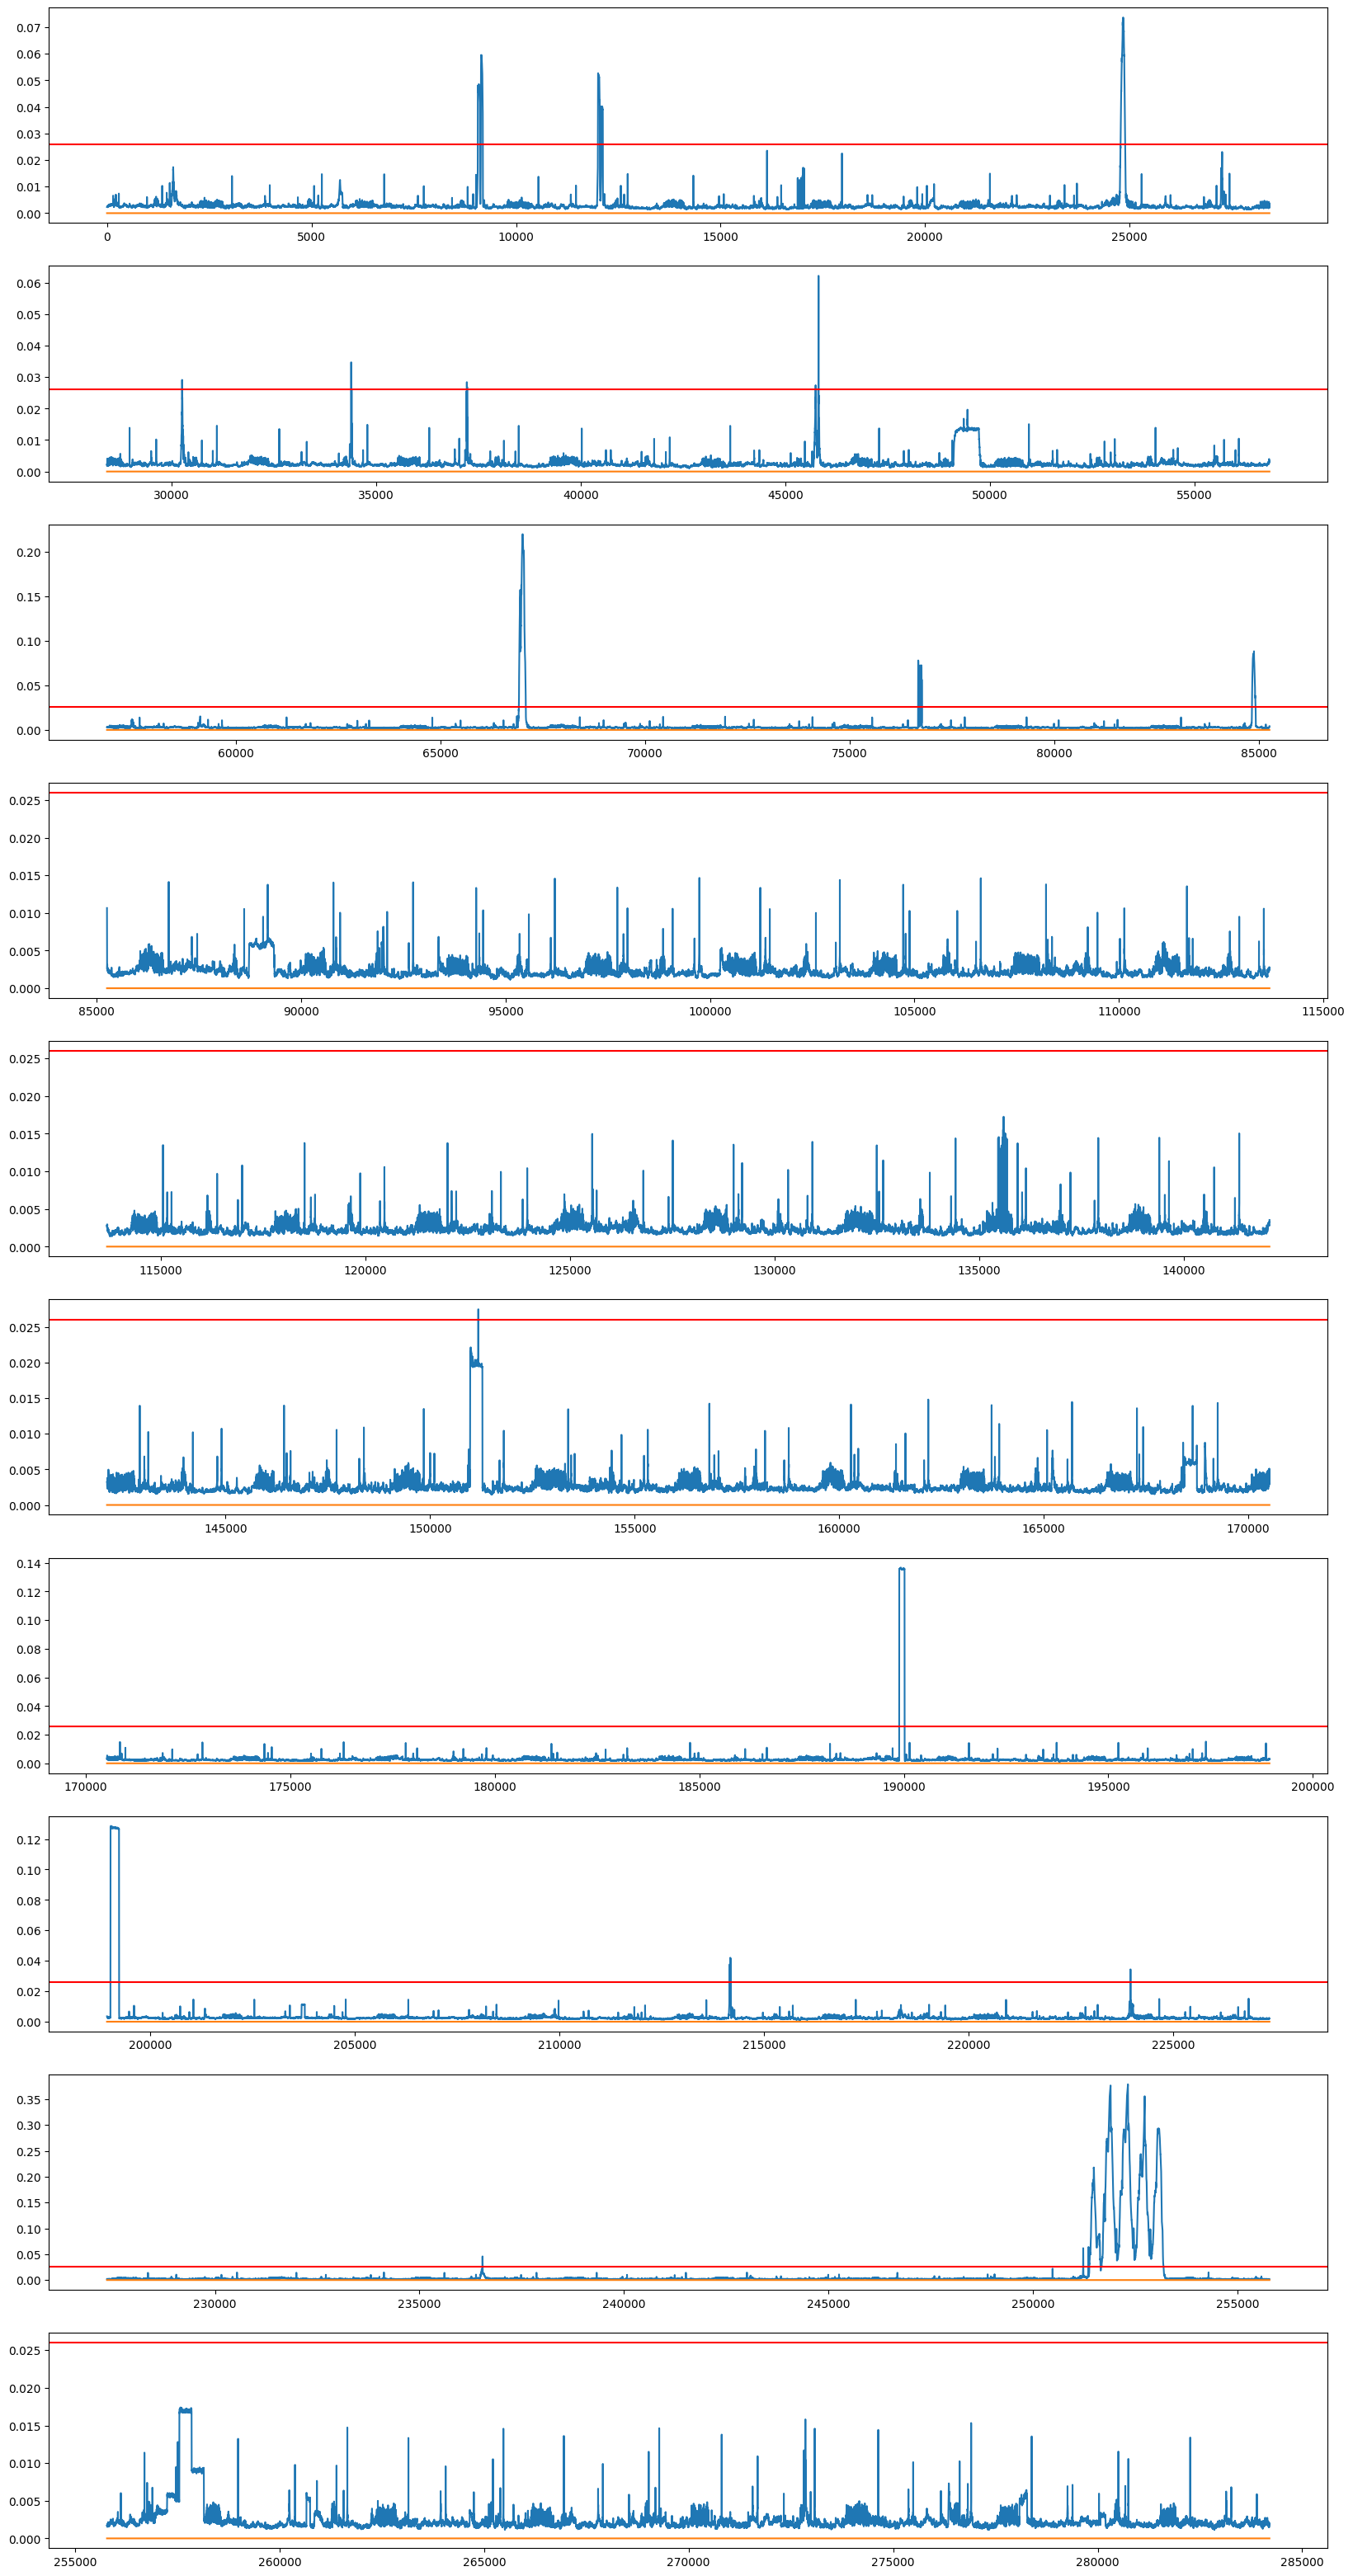

In [ ]:
THRESHOLD = 0.026
check_graph(ANOMALY_SCORE_1, CHECK_ATT_1, piece=10, THRESHOLD=THRESHOLD)

In [ ]:
LABELS_1 = put_labels(ANOMALY_SCORE_1, THRESHOLD)
LABELS_1, LABELS_1.shape

(array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), (284202,))

In [ ]:
unique, counts = np.unique(LABELS_1, return_counts=True)

label_counts = dict(zip(unique, counts))

print("Количество каждого значения в LABELS:")
print(label_counts)

Количество каждого значения в LABELS:
{np.float32(0.0): np.int64(281372), np.float32(1.0): np.int64(2830)}


Предсказания 

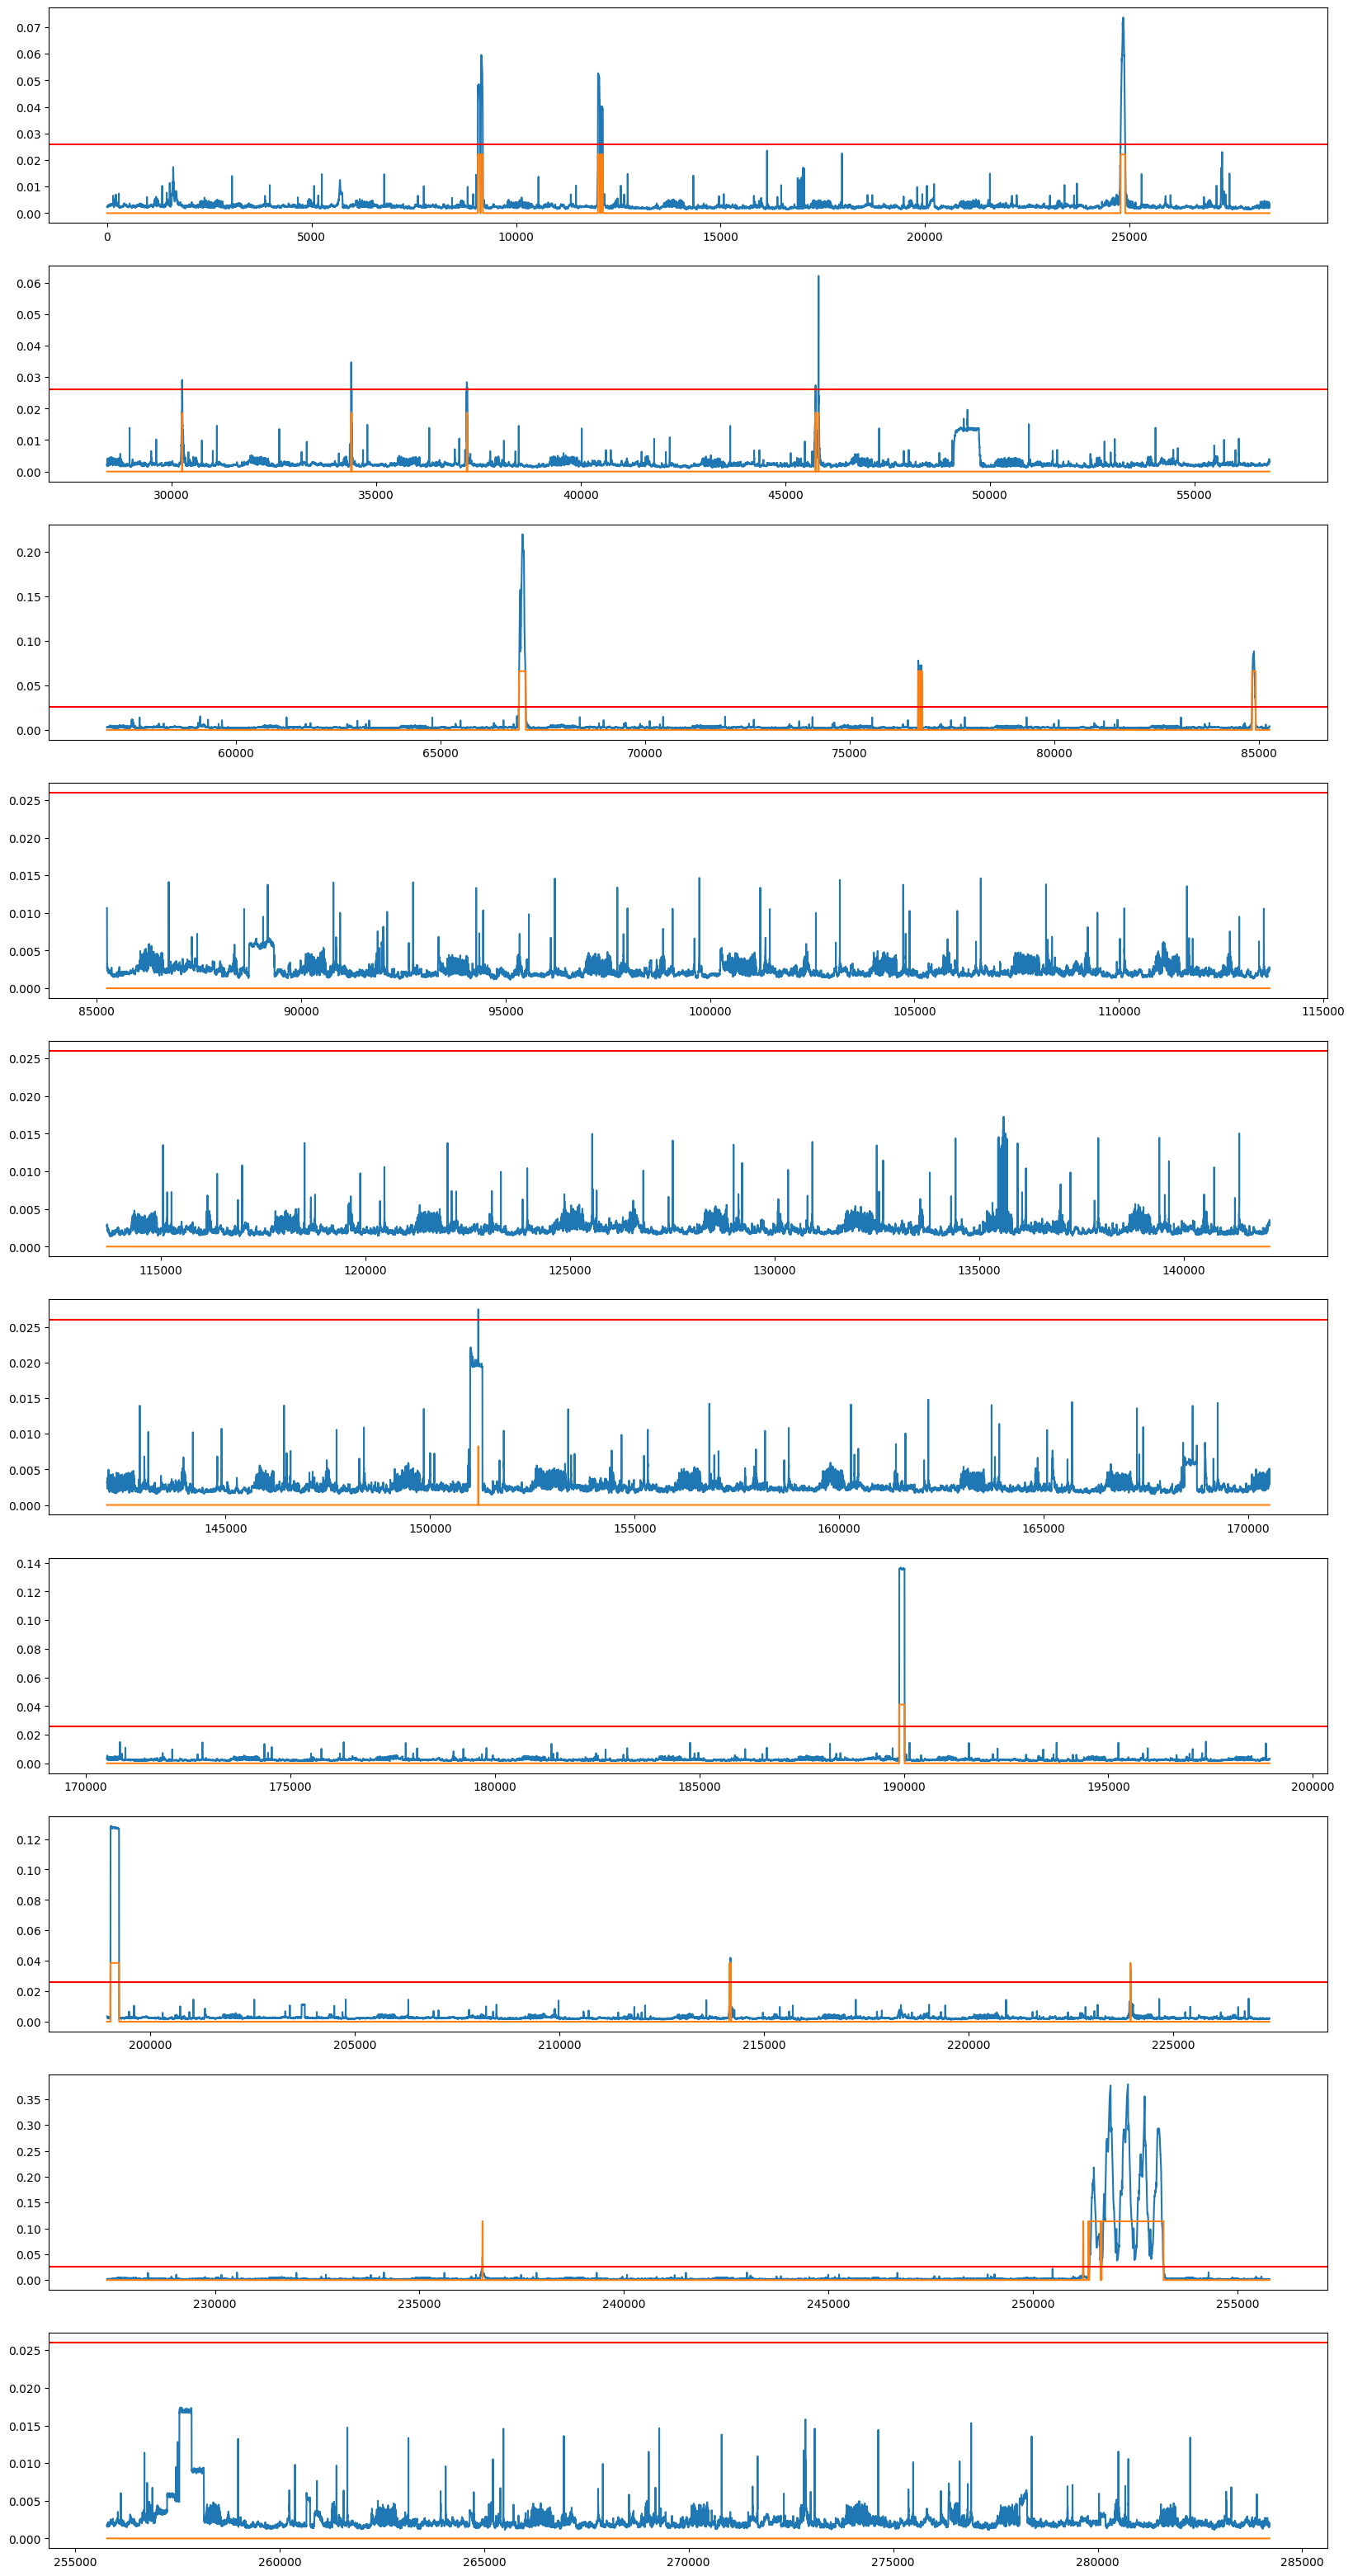

In [ ]:
check_graph(ANOMALY_SCORE_1, LABELS_1, piece=10, THRESHOLD=THRESHOLD)

In [ ]:
attacks_predict_1 = pd.DataFrame({
    'timestamp': CHECK_TS_1,   
    'attack': LABELS_1         
})

In [ ]:
attacks_predict_1['timestamp'] = pd.to_datetime(attacks_predict_1['timestamp'])
LABEL_DF_RAW['timestamp'] = pd.to_datetime(LABEL_DF_RAW['timestamp'])

In [ ]:
merged_df_1 = pd.merge(LABEL_DF_RAW, attacks_predict_1, on='timestamp', how='left')
merged_df_1['attack'] = merged_df_1['attack'].fillna(0)

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
f1 = f1_score(merged_df_1["label"], merged_df_1["attack"])
print("f1 score: ", f1)

f1 score:  0.3542985788659069


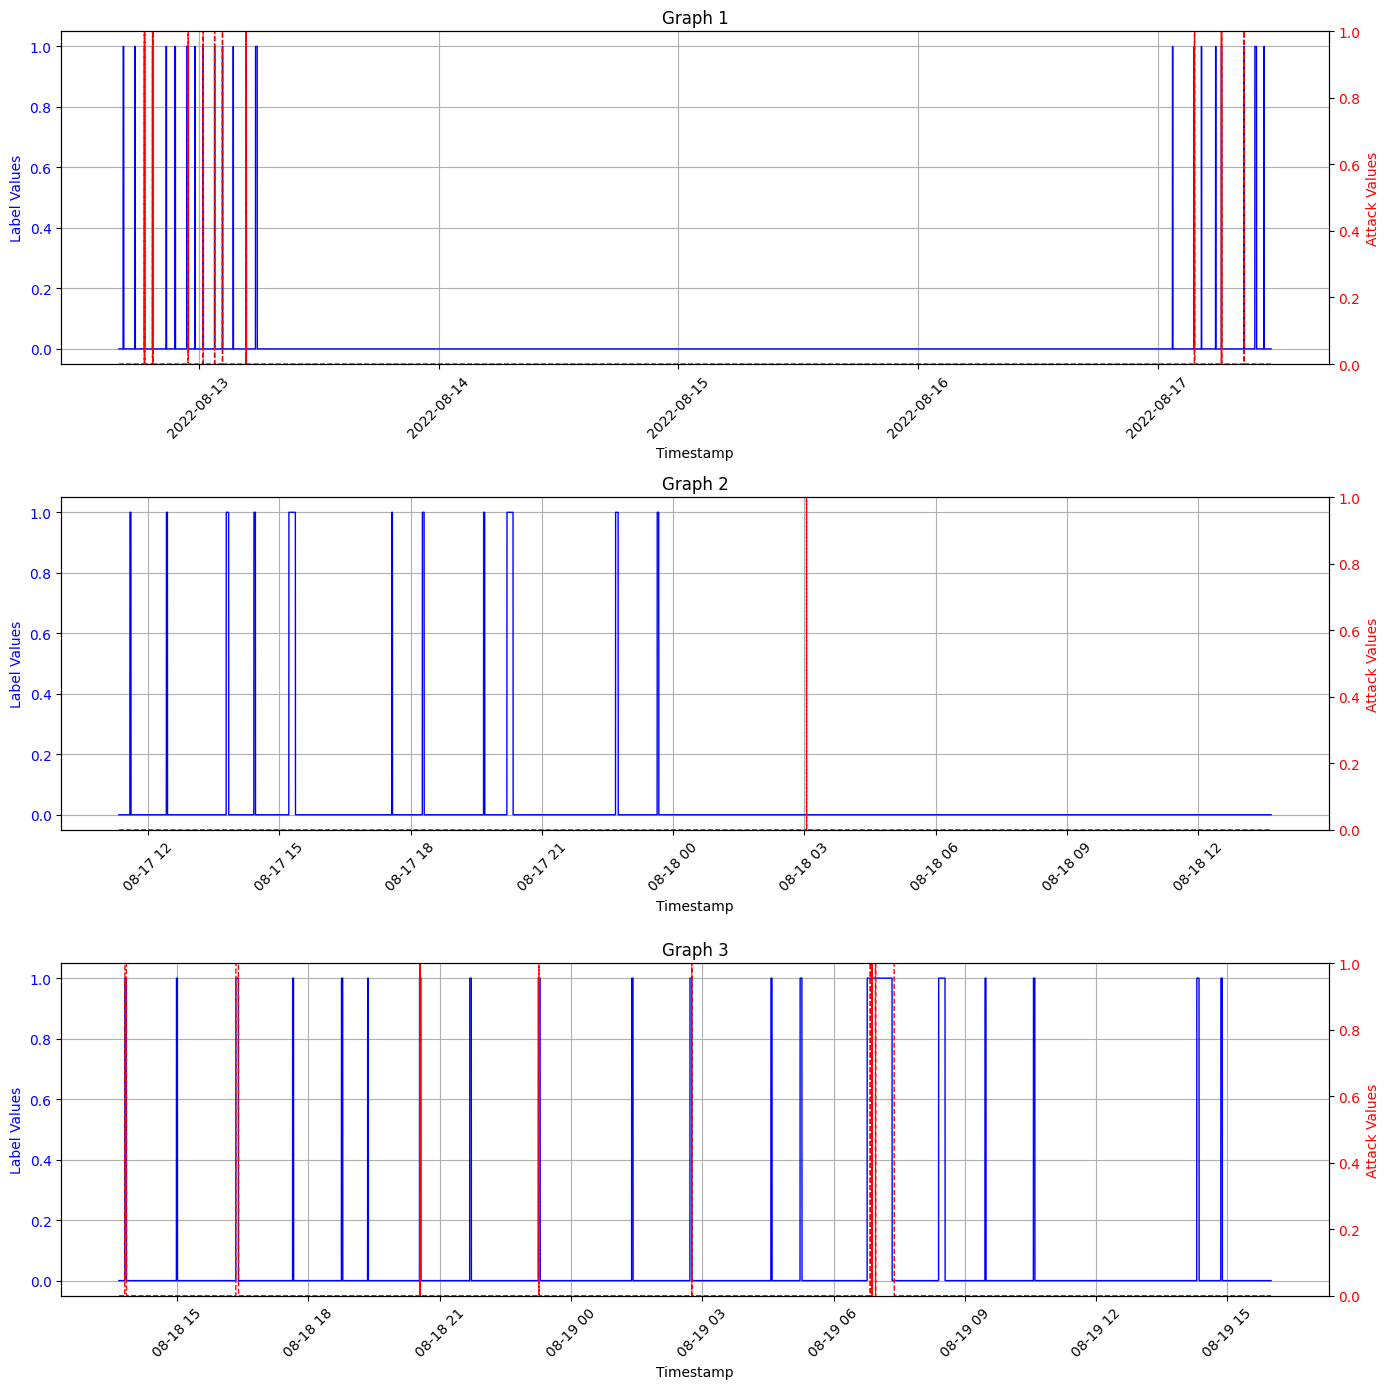

In [ ]:
n_splits = 3

# Определяем количество строк в одном интервале
rows_per_split = len(merged_df_1) // n_splits

fig, axes = plt.subplots(n_splits, 1, figsize=(14, 14))

for i in range(n_splits):
    start_idx = i * rows_per_split
    if i == n_splits - 1:
        end_idx = len(merged_df_1)
    else:
        end_idx = (i + 1) * rows_per_split

    sub_df = merged_df_1.iloc[start_idx:end_idx]
    
    ax1 = axes[i]
    ax1.plot(sub_df['timestamp'], sub_df['label'], label='Label', color='blue', linewidth=1)
    ax1.set_xlabel('Timestamp')
    ax1.set_ylabel('Label Values', color='blue')
    ax1.tick_params(axis='x', rotation=45)
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.grid(True)
    
    ax2 = ax1.twinx()  
    ax2.plot(sub_df['timestamp'], sub_df['attack'], label='Attack', color='red', linestyle='--', linewidth=1)
    ax2.set_ylabel('Attack Values', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    ax2.set_ylim(0, 1)

    ax1.set_title(f'Graph {i+1}')


plt.tight_layout()
plt.show()